<a href="https://colab.research.google.com/github/tk1cntt/catboost-samples/blob/ea/catboost_conditional_GBPUSD_m5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     |████████████████████████████████| 65.8MB 61kB/s 


In [55]:
#import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime
import random
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import mixture

import warnings
warnings.filterwarnings('ignore')

#mt5.initialize()

MA_PERIODS = [5, 15, 25, 50, 75,
              100, 125, 150, 200, 250, 300, 350, 400, 450, 500]

SYMBOL = 'GBPUSD'
MARKUP = 0.00200
#TIMEFRAME = mt5.TIMEFRAME_H1
START_DATE = datetime(2017, 1, 1)
TSTART_DATE = datetime(2015, 1, 1)
FULL_DATE = datetime(2015, 1, 1)
STOP_DATE = datetime(2022, 1, 1)
hours = [5]
minutes = [0, 15, 30, 45]
n_compnents = 75

def v2get_prices():
  df_prices = pd.read_csv("./sample_data/GBPUSD_mt5_bars_m5_2020.csv")[['date', 'time', 'close']]
  return get_prices(df_prices)

def v2get_prices_test():
  df_prices = pd.read_csv("./sample_data/GBPUSD_mt5_bars_m5_2019.csv")[['date', 'time', 'close']]
  return get_prices(df_prices)

def get_prices(df_prices):
  cb_prices = pd.DataFrame()
  cb_prices['sdate'] = df_prices['date'].astype(str) + " " + df_prices['time']
  cb_prices['time'] = pd.to_datetime(cb_prices.sdate, format='%Y%m%d %H:%M:%S')
  cb_prices['close'] = df_prices['close']
  #cb_prices['time'] = cb_prices.stime.values.astype(np.int64)
  cb_prices.set_index('time')
  cb_prices.index = pd.to_datetime(cb_prices.time, unit='s')
  cb_prices = cb_prices.drop(columns=['sdate', 'time'])
  pr = cb_prices.copy()
  count = 0
  for i in MA_PERIODS:
    cb_prices[str(count)] = pr['close'] - pr['close'].rolling(i).mean()
    count += 1
  return cb_prices.dropna()


In [56]:

def add_labels(dataset, max):
    labels = []
    for i in range(dataset.shape[0]-max):
        curr_pr = dataset['close'][i]
        trend = 2.0
        for j in range(1, max):
          future_pr = dataset['close'][i+j]
          if ((future_pr + MARKUP) < curr_pr):
              trend = 1.0
              break
          elif ((future_pr - MARKUP) > curr_pr):
              trend = 0.0
              break
        labels.append(trend)
    dataset = dataset.iloc[:len(labels)].copy()
    dataset['labels'] = labels
    dataset = dataset.dropna()
    dataset = dataset.drop(
        dataset[dataset.labels == 2].index)

    return dataset




In [49]:
pr = v2get_prices()
print('Number of rows: {}, Number of columns: {}'.format(*pr.shape))
prh = add_labels(pr, max=5)
print('Number of rows: {}, Number of columns: {}'.format(*prh.shape))

Number of rows: 74139, Number of columns: 16
Number of rows: 5390, Number of columns: 17


In [100]:

def tester(dataset, sl, tp,  plot=False):
    last_deal = int(2)
    last_price = 0.0
    report = [0.0]
    for i in range(dataset.shape[0]):
        pred = dataset['labels'][i]
        if last_deal == 2:
            last_price = dataset['close'][i]
            last_deal = 0 if pred <= 0.5 else 1
            continue
        if last_deal == 0:
            if (dataset['close'][i] - tp > last_price):
                last_deal = 2
                report.append(report[-1] + tp)
                continue
            if (dataset['close'][i] + sl < last_price):
                last_deal = 2
                report.append(report[-1] - sl)
                continue
        if last_deal == 1:
            if (dataset['close'][i] + tp < last_price):
                last_deal = 2
                report.append(report[-1] + tp)
                continue
            if (dataset['close'][i] - sl > last_price):
                last_deal = 2
                report.append(report[-1] - sl)
                continue

    y = np.array(report).reshape(-1, 1)
    X = np.arange(len(report)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, y)

    l = lr.coef_
    if l >= 0:
        l = 1
    else:
        l = -1

    if(plot):
        plt.plot(report)
        plt.plot(lr.predict(X))
        plt.title("Strategy performance")
        plt.xlabel("the number of trades")
        plt.ylabel("cumulative profit in pips")
        plt.show()

    return lr.score(X, y) * l, report


def brute_force(samples, gmm):
    # # make dataset
    # pr = get_prices(START_DATE, STOP_DATE)
    # pr = add_labels(pr, min=5, max=25, filter=time_filter)
    # # tester(pr, MARKUP, plot=True, filter=time_filter)
    # pr = pr[pr.columns[1:]]
    # # perform GMM clasterizatin over dataset
    # prUp = pr[pr['labels'] == 0]
    # prDwn = pr[pr['labels'] == 1]
    # gmmUp = mixture.GaussianMixture(
    #     n_components=n_compnents, covariance_type='full', n_init=1).fit(prUp[prUp.columns[:-1]])
    # gmmDwn = mixture.GaussianMixture(
    #     n_components=n_compnents, covariance_type='full', n_init=1).fit(prDwn[prDwn.columns[:-1]])

    # # sample new dataset
    # generatedUp = gmmUp.sample(samples)
    # generatedDwn = gmmDwn.sample(samples)

    # genUp = pd.DataFrame(generatedUp[0])
    # genUp['labels'] = 0
    # genDwn = pd.DataFrame(generatedDwn[0])
    # genDwn['labels'] =1

    # gen = pd.concat([genUp, genDwn])
    # sample new dataset

    # sample new dataset
    generated = gmm.sample(samples)
    # make labels
    gen = pd.DataFrame(generated[0])
    gen.rename(columns={gen.columns[-1]: "labels"}, inplace=True)
    gen.loc[gen['labels'] >= 0.5, 'labels'] = 1
    gen.loc[gen['labels'] < 0.5, 'labels'] = 0

    X = gen[gen.columns[:-1]]
    y = gen[gen.columns[-1]]

    X = gen[gen.columns[:-1]]
    y = gen[gen.columns[-1]]

    # train\test split
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, train_size=0.5, test_size=0.5, shuffle=True)
    # learn with train and validation subsets
    model = CatBoostClassifier(iterations=1000,
                               depth=6,
                               learning_rate=0.01,
                               custom_loss=['Accuracy'],
                               eval_metric='Accuracy',
                               verbose=False,
                               use_best_model=True,
                               task_type='CPU')
    model.fit(train_X, train_y, eval_set=(test_X, test_y),
              early_stopping_rounds=25, plot=False)
    # test on new data
    pr_tst = v2get_prices_test()
    X = pr_tst[pr_tst.columns[1:]]
    X.columns = [''] * len(X.columns)

    # test the learned model
    p = model.predict_proba(X)
    p2 = [x[0] < 0.5 for x in p]
    pr2 = pr_tst.iloc[:len(p2)].copy()
    pr2['labels'] = p2

    R2, report = tester(pr2, 0.001, 0.002, plot=False)
    report.sort()
    
    return [R2, model, report[-1]]


def test_model(result, sl=0.001, tp=0.002, plot=False):
    pr_tst = v2get_prices_test()
    X = pr_tst[pr_tst.columns[1:]]
    X.columns = [''] * len(X.columns)

    # test the learned model
    p = result[1].predict_proba(X)
    p2 = [x[0] < 0.5 for x in p]
    pr2 = pr_tst.iloc[:len(p2)].copy()
    pr2['labels'] = p2
    R2, report = tester(pr2, sl, tp, plot=True)
    report.sort()
    print("Score:", report[-1])



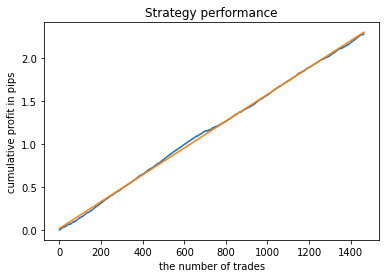

0.9991184836581375

In [85]:
pr = v2get_prices()
pr = add_labels(pr, max=5)
tester(pr, 0.001, 0.002, plot=True)

In [88]:
def get_report(model):
    return model[2]

def export_model_to_MQL_code(model, name):
    model.save_model('catmodel_'+name+ '.h',
    format="cpp",
    export_parameters=None,
    pool=None)

    # add variables
    code = 'int hnd[];\n'
    code += 'int OnInit() {\n'
    code +=     'ArrayResize(hnd,' + str(len(MA_PERIODS)) + ');\n'

    count = len(MA_PERIODS) - 1
    for i in MA_PERIODS:
        code +=     'hnd[' + str(count) + ']' + ' =' + ' iMA(NULL,PERIOD_CURRENT,' + str(i) + ',0,MODE_SMA,PRICE_CLOSE);\n'
        count -= 1

    code += 'return(INIT_SUCCEEDED);\n'
    code += '}\n\n'

    # get features
    code += 'void fill_arays(double &features[]) {\n'
    code += '   double ma[], pr[], ret[];\n'
    code += '   ArrayResize(ret,' + str(len(MA_PERIODS)) +');\n'
    code += '   CopyClose(NULL,PERIOD_CURRENT,1,1,pr);\n'
    code += '   for(int i=0;i<' + str(len(MA_PERIODS)) +';i++) {\n'
    code += '       CopyBuffer(hnd[' + 'i' + '], 0, 1, 1, ma);\n'
    code += '       ret[i] = pr[0] - ma[0];\n }\n'
    code += '   ArrayInsert(features, ret, ArraySize(features), 0, WHOLE_ARRAY);'
    code += '   ArraySetAsSeries(features, true);\n'
    code += '}\n\n'

    # add CatBosst
    code += 'double catboost_model' + '(const double &features[]) { \n'
    code += '    '
    with open('catmodel_'+name+ '.h', 'r') as file:
        data = file.read()
        code += data[data.find("unsigned int TreeDepth"):data.find("double Scale = 1;")]
    code +='\n\n'
    code+= 'return ' + 'ApplyCatboostModel(features, TreeDepth, TreeSplits , BorderCounts, Borders, LeafValues); } \n\n'

    code += 'double ApplyCatboostModel(const double &features[],uint &TreeDepth_[],uint &TreeSplits_[],uint &BorderCounts_[],float &Borders_[],double &LeafValues_[]) {\n\
    uint FloatFeatureCount=ArrayRange(BorderCounts_,0);\n\
    uint BinaryFeatureCount=ArrayRange(Borders_,0);\n\
    uint TreeCount=ArrayRange(TreeDepth_,0);\n\
    bool     binaryFeatures[];\n\
    ArrayResize(binaryFeatures,BinaryFeatureCount);\n\
    uint binFeatureIndex=0;\n\
    for(uint i=0; i<FloatFeatureCount; i++) {\n\
       for(uint j=0; j<BorderCounts_[i]; j++) {\n\
          binaryFeatures[binFeatureIndex]=features[i]>Borders_[binFeatureIndex];\n\
          binFeatureIndex++;\n\
       }\n\
    }\n\
    double result=0.0;\n\
    uint treeSplitsPtr=0;\n\
    uint leafValuesForCurrentTreePtr=0;\n\
    for(uint treeId=0; treeId<TreeCount; treeId++) {\n\
       uint currentTreeDepth=TreeDepth_[treeId];\n\
       uint index=0;\n\
       for(uint depth=0; depth<currentTreeDepth; depth++) {\n\
          index|=(binaryFeatures[TreeSplits_[treeSplitsPtr+depth]]<<depth);\n\
       }\n\
       result+=LeafValues_[leafValuesForCurrentTreePtr+index];\n\
       treeSplitsPtr+=currentTreeDepth;\n\
       leafValuesForCurrentTreePtr+=(1<<currentTreeDepth);\n\
    }\n\
    return 1.0/(1.0+MathPow(M_E,-result));\n\
    }'

    file = open('./' + 'catmodel_'+name+ '.mqh', "w")
    file.write(code)
    file.close()
    print('The file ' + 'cat_model' + '.mqh ' + 'has been written to disc')

# make dataset
def final_test_model(_h, loop=20):
  pr = v2get_prices()
  pr = add_labels(pr, max=_h)
  tester(pr, 0.001, 0.002, plot=True)
  
  # perform GMM clasterizatin over dataset
  # gmm = mixture.BayesianGaussianMixture(n_components=n_compnents, covariance_type='full').fit(X)
  gmm = mixture.GaussianMixture(
      n_components=n_compnents, covariance_type='full', n_init=1).fit(pr[pr.columns[1:]])

  # iterative learning
  res = []
  model_score = []
  for i in range(loop):
      res.append(brute_force(10000, gmm))
      print('Iteration: ', i, 'R^2: ', res[-1][0])
      test_model(res[-1], 0.001, 0.002, plot=True)

  print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
  # test best model
  res.sort()
  print("Best model score:", res[-1][0], ' report score:', res[-1][2])
  test_model(res[-1], plot=True)
  export_model_to_MQL_code(res[-1][1], 'best_model_eurusd_' + str(hours[0]) + 'h_keep_' + str(_h) + 'h')

  res.sort(key=get_report)
  print("Best report score:", res[-1][2], ' model score:', res[-1][0])
  test_model(res[-1], plot=True)
  export_model_to_MQL_code(res[-1][1], 'best_score_eurusd_' + str(hours[0]) + 'h_keep_' + str(_h) + 'h')
  print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

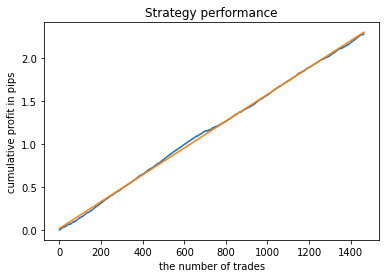

Iteration:  0 R^2:  0.9719089710011446


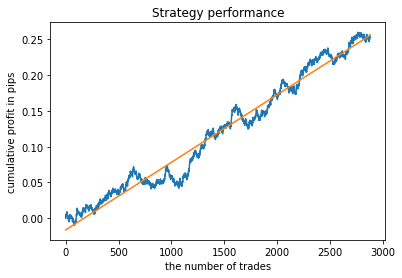

Score: 0.2600000000000002
Iteration:  1 R^2:  0.5629450598480393


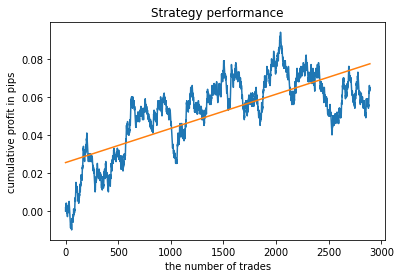

Score: 0.09400000000000003
Iteration:  2 R^2:  0.674859771669269


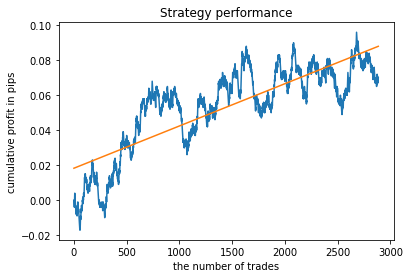

Score: 0.09600000000000002
Iteration:  3 R^2:  0.7514767522152145


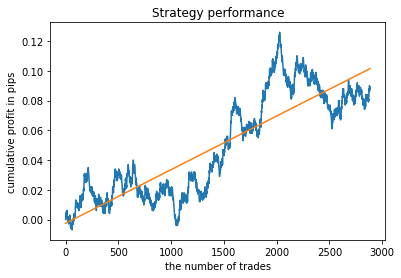

Score: 0.12599999999999997
Iteration:  4 R^2:  0.940286764431016


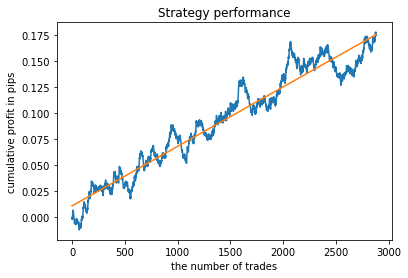

Score: 0.17800000000000013
Iteration:  5 R^2:  -0.18217000596777733


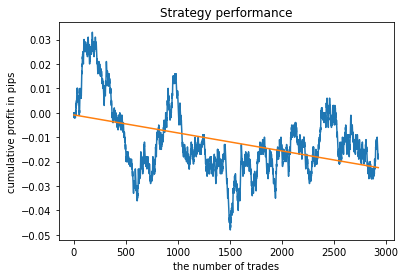

Score: 0.033000000000000015
Iteration:  6 R^2:  0.34860745780240576


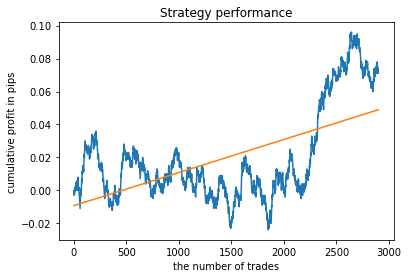

Score: 0.0959999999999999
Iteration:  7 R^2:  0.8953826346073862


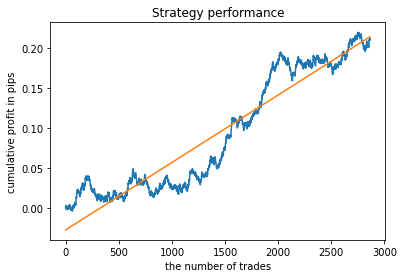

Score: 0.22000000000000008
Iteration:  8 R^2:  0.8027836506667803


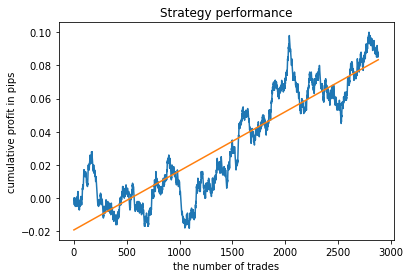

Score: 0.09999999999999992
Iteration:  9 R^2:  0.56200176776383


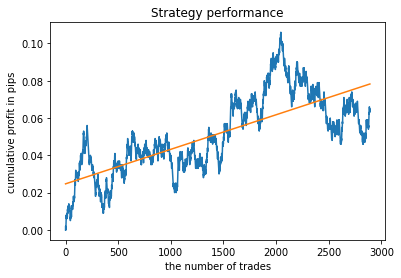

Score: 0.10600000000000005
Iteration:  10 R^2:  0.9289568237944423


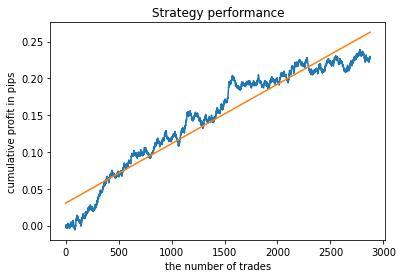

Score: 0.23900000000000016
Iteration:  11 R^2:  0.6724507693679602


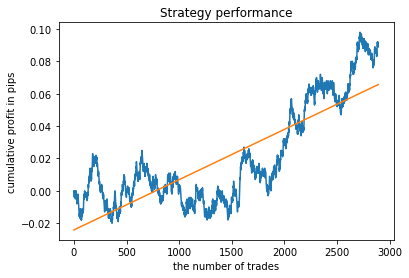

Score: 0.09799999999999986
Iteration:  12 R^2:  0.9401328256334077


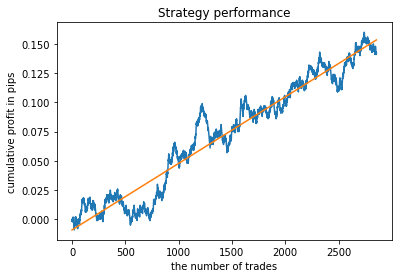

Score: 0.16000000000000006
Iteration:  13 R^2:  0.7829935928955959


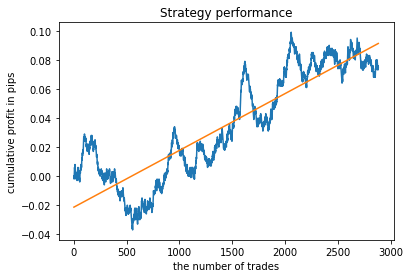

Score: 0.099
Iteration:  14 R^2:  0.5760206287001043


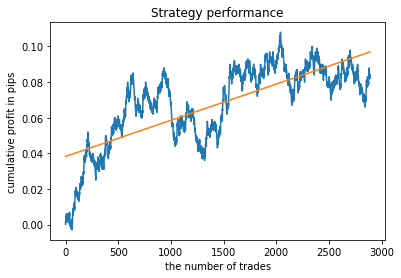

Score: 0.10800000000000007
Iteration:  15 R^2:  0.812188572513768


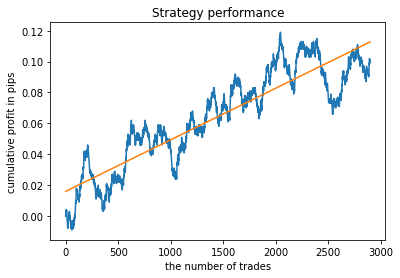

Score: 0.11900000000000005
Iteration:  16 R^2:  0.7169926774639606


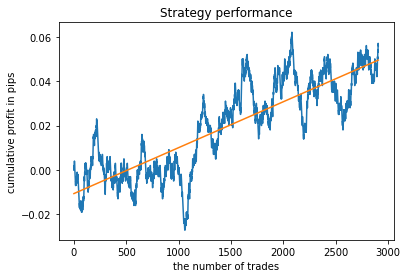

Score: 0.061999999999999944
Iteration:  17 R^2:  0.9408876190052404


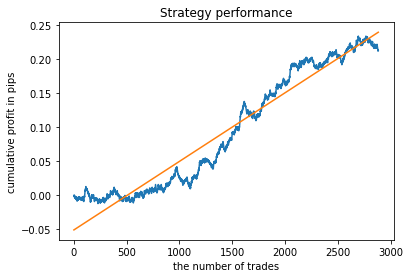

Score: 0.23400000000000012
Iteration:  18 R^2:  0.9352271370736227


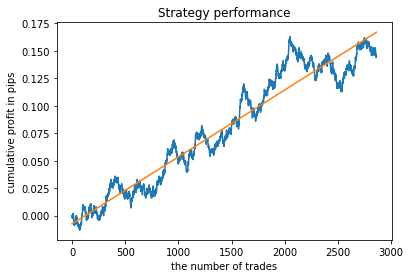

Score: 0.1630000000000001
Iteration:  19 R^2:  0.9605106519947184


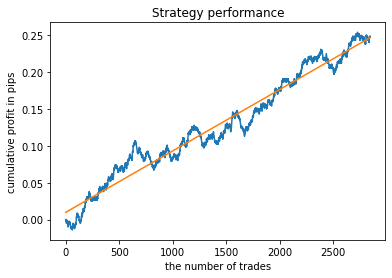

Score: 0.25400000000000017
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Best model score: 0.9719089710011446  report score: 0.2600000000000002


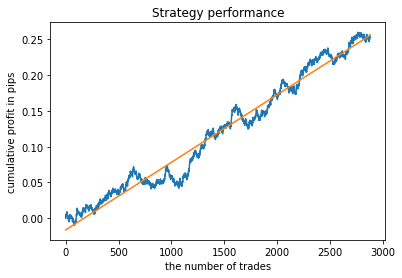

Score: 0.2600000000000002
Best report score: 0.2600000000000002  model score: 0.9719089710011446


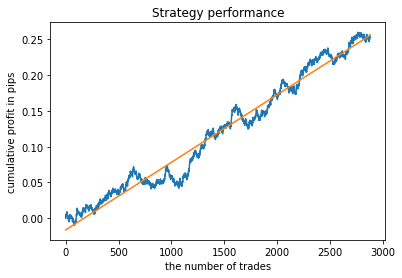

Score: 0.2600000000000002
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [101]:
final_test_model(5, 20)

In [102]:
def v2deals_frequency_analyzer():
    kfreq = [x for x in range(2, 12)]
    pr = v2get_prices()
    result = pd.DataFrame()
    for _ih in kfreq:
      prh = pr.copy()
      prh = add_labels(prh, max=_ih)
      #gmm = mixture.GaussianMixture(n_components=n_compnents, covariance_type='full', n_init=1).fit(prh[prh.columns[1:]])
      gmm = mixture.BayesianGaussianMixture(n_components=n_compnents, covariance_type='full').fit(prh[prh.columns[1:]])
      # iterative learning
      res = []
      iterations = 5
      for i in range(iterations):
          res.append(brute_force(10000, gmm))
          print('Iteration: ', i, 'R^2: ', res[-1][0],' deal keep time = ', _ih*5, ' minutes')
      r = pd.DataFrame(np.array(res)[:, 0], np.full(iterations,_ih))
      result = result.append(r)
    plt.scatter(result.index, result, c = result.index)
    plt.xticks(np.arange(1, len(kfreq)+1, 1))
    plt.title("Performance by deals lifetime")
    plt.xlabel("deals frequency")
    plt.ylabel("R^2 estimation")
    plt.show()
    return 0

Iteration:  0 R^2:  0.8712067531298465  deal keep time =  10  minutes
Iteration:  1 R^2:  0.9426567834683978  deal keep time =  10  minutes
Iteration:  2 R^2:  0.9525343601547814  deal keep time =  10  minutes
Iteration:  3 R^2:  0.458903608879741  deal keep time =  10  minutes
Iteration:  4 R^2:  0.04659390816590059  deal keep time =  10  minutes
Iteration:  0 R^2:  0.1936375476995269  deal keep time =  15  minutes
Iteration:  1 R^2:  0.035597999564375815  deal keep time =  15  minutes
Iteration:  2 R^2:  0.8681182569504053  deal keep time =  15  minutes
Iteration:  3 R^2:  -0.00952607315533216  deal keep time =  15  minutes
Iteration:  4 R^2:  0.49627357057161897  deal keep time =  15  minutes
Iteration:  0 R^2:  0.9185656821702622  deal keep time =  20  minutes
Iteration:  1 R^2:  0.6398684253654852  deal keep time =  20  minutes
Iteration:  2 R^2:  -0.7453309515011056  deal keep time =  20  minutes
Iteration:  3 R^2:  0.32298147438575336  deal keep time =  20  minutes
Iteration:  4

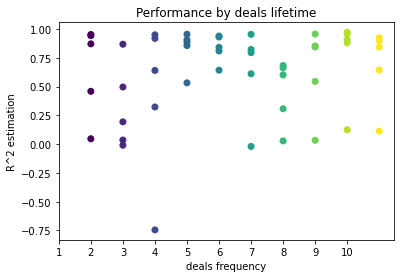

In [103]:
r = v2deals_frequency_analyzer()